In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from scipy.stats import chi2_contingency
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from statsmodels.formula.api import ols
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Data Exploration

After the import of <b>all</b> the required libraries as shown above, the next step is to get the data into a dataframe.

From each of the excel file, we would extract out the date length of stay and in-hospital death and place them in a <b>Target</b> dataframe. The in each folder: fold1, fold2, fold3, and fold4, we would extract out all the data and sort them into two different dataframe, <b>General</b> and <b>Temporal</b>.There is an additional dataframe generate from <b>Temporal</b>, which is <b>Features</b>. This stores all of the measured features according to their respective time and recordID. Each folder would have their own dataframe to separate the different folds. These two different dataframes would be each kept in a list: `temporal_df_data` and `general_df_data`.

In [2]:
dir_path = os.getcwd()
# print(dir_path)
#data_path = str(dir_path) + "\Project_Data\\"
data_path = str(dir_path) + "/Project_Data/"
# print(data_path)

excel_files = ["Fold1_Outcomes.csv", "Fold2_Outcomes.csv", "Fold3_Outcomes.csv", "Fold4_Outcomes.csv"]
folders = ["fold1", "fold2", "fold3", "fold4"]
parameters = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight', 'GCS', 'HR', 'NIDiasABP', 'NIMAP', 'NISysABP', 
              'RespRate', 'Temp', 'Urine', 'HCT', 'BUN', 'Creatinine', 'Glucose', 'HCO3', 'Mg', 'Platelets', 'K', 'Na', 
              'WBC', 'pH', 'PaCO2', 'PaO2', 'DiasABP', 'FiO2', 'MAP', 'MechVent', 'SysABP', 'SaO2', 'Albumin', 'ALP', 
              'ALT', 'AST', 'Bilirubin', 'Lactate', 'Cholesterol', 'TroponinI', 'TroponinT']
static_parameters = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']
patients = []
target_df_data = []

for file_name in excel_files:
    df = pd.read_csv(data_path + file_name)
    df.columns = ["RecordID", 'Length_of_stay', 'In-hospital_death']
    target_df_data.append(df)

temp_data = {}
general_desc = {}
temporal_df_data = []
general_df_data = []


for folder_name in folders:
    temporal_data = []
    general_data = []
    for file_name in os.listdir(data_path + folder_name):
        record_id = file_name.split('.')[0]
        patients.append(record_id)
        patient_general_data = []
        patient_general_data.append(record_id)
        #file = open(data_path + folder_name + "\\" + file_name, "r")
        file = open(data_path + folder_name + "/" + file_name, "r", encoding='windows-1252')
        count = 0
        for file_data in file.readlines(): 
            if (count > 1):
                time = file_data.split(',')[0]
                parameter = file_data.split(',')[1]
                value = file_data.split(',')[2]
                value = value.replace('\n','')
                if (time == '00:00' and parameter in static_parameters):
                    general_desc[record_id,parameter] = [value]
                    patient_general_data.append(value)
                    #print(patient_general_data)
                else:
                    temp_data[record_id + ',' + time + ',' + parameter] = [time, parameter, value]
                    temporal_data.append([record_id, time, parameter, value])
            count += 1
        general_data.append(patient_general_data)
            
        
    #tranform the general data into a dataframe 
    general_df = pd.DataFrame(general_data) 
    general_df.columns = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']
    general_df_data.append(general_df)
    general_data = []
    
    #tranform the temporal data into a dataframe
    temporal_df = pd.DataFrame(temporal_data)
    temporal_df.columns = ["RecordID", "Time", "Parameter", "Value"]
    temporal_df_data.append(temporal_df)
    temporal_data = []
    

#sort dataframe to follow 4 outcome folds
for i in general_df_data:
    i.sort_values('RecordID', inplace=True)
    
for i in temporal_df_data:
    i.sort_values('RecordID', inplace=True)

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(general_df_data[0].sort_values('RecordID', inplace=True))

In [3]:
features_df_data = []
previous_time = -1

column_names = ['RecordID', 'Time', 'GCS', 'HR', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Weight',
              'RespRate', 'Temp', 'Urine', 'HCT', 'BUN', 'Creatinine', 'Glucose', 'HCO3', 'Mg', 'Platelets', 'K', 'Na', 
              'WBC', 'pH', 'PaCO2', 'PaO2', 'DiasABP', 'FiO2', 'MAP', 'MechVent', 'SysABP', 'SaO2', 'Albumin', 'ALP', 
              'ALT', 'AST', 'Bilirubin', 'Lactate', 'Cholesterol', 'TroponinI', 'TroponinT']

patient_features_data = [0 for i in range(39)]
record_id = 0

for folder_name in folders:
    features_data = []
    for file_name in os.listdir(data_path + folder_name):
        record_id = file_name.split('.')[0]
        #file = open(data_path + folder_name + "\\" + file_name, "r")
        file = open(data_path + folder_name + "/" + file_name, "r", encoding='windows-1252')
        count = 0
        for file_data in file.readlines(): 
            if (count > 1):
                time = file_data.split(',')[0]
                parameter = file_data.split(',')[1]
                value = file_data.split(',')[2]
                value = value.replace('\n','')
                if (time != '00:00' or parameter not in static_parameters):
                    if (previous_time != time):
                        previous_time = time
                        if (patient_features_data[0] != 0):
                            features_data.append(patient_features_data)
                        patient_features_data = [0 for i in range(39)]
                        patient_features_data[0] = record_id
                        patient_features_data[1] = time
                    index = column_names.index(parameter)
                    patient_features_data[index] = float(value)
            count += 1
        
    features_df = pd.DataFrame(features_data)
    features_df.columns = ['RecordID', 'Time', 'GCS', 'HR', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Weight',
              'RespRate', 'Temp', 'Urine', 'HCT', 'BUN', 'Creatinine', 'Glucose', 'HCO3', 'Mg', 'Platelets', 'K', 'Na', 
              'WBC', 'pH', 'PaCO2', 'PaO2', 'DiasABP', 'FiO2', 'MAP', 'MechVent', 'SysABP', 'SaO2', 'Albumin', 'ALP', 
              'ALT', 'AST', 'Bilirubin', 'Lactate', 'Cholesterol', 'TroponinI', 'TroponinT']
    features_df_data.append(features_df)
    
for target_data in target_df_data:
    target_data.replace({'Length_of_stay': -1}, 2)
    
    
#sort dataframe to follow 4 outcome folds
for i in features_df_data:
    i.sort_values('RecordID', inplace=True)

To know more about the data, we take a look at what is stored in the dataframes.
<b>General</b> and <b>Excel</b> dataframes each contains 1,000 rows of patients information.
<b>Temporal</b> having a row for each timestamp and parameter pair for each patient, would contain more than 1,000 rows.

In [4]:
target_df_data[0].info()
general_df_data[0].info()
temporal_df_data[0].info()
features_df_data[0].info()

#list of dataframes
print(target_df_data[0].head())
print(general_df_data[0].head())
print(general_df_data[0].describe())
print(temporal_df_data[0].head())
print(features_df_data[0].head())

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(features_df_data[0])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
RecordID             1000 non-null int64
Length_of_stay       1000 non-null int64
In-hospital_death    1000 non-null int64
dtypes: int64(3)
memory usage: 23.5 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 631 to 370
Data columns (total 6 columns):
RecordID    1000 non-null object
Age         1000 non-null object
Gender      1000 non-null object
Height      1000 non-null object
ICUType     1000 non-null object
Weight      1000 non-null object
dtypes: object(6)
memory usage: 54.7+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 432026 entries, 269167 to 156897
Data columns (total 4 columns):
RecordID     432026 non-null object
Time         432026 non-null object
Parameter    432026 non-null object
Value        432026 non-null object
dtypes: object(4)
memory usage: 16.5+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 73284 entries, 45688 to 26412
Data co

## Missing Variables



We assume that the data given for the target variables are perfect with no missing or unnatural values. The following counts the number of null values for all dataframes created in above steps.

In [5]:
i = 0
print('General df:')
while (i < 4 ):
    missing = pd.DataFrame(general_df_data[i].isnull().sum()).rename(columns = {0: 'total'})
    print(missing)
    i = i + 1

i = 0    
print('Temporal df:')    
while (i < 4 ):
    missing = pd.DataFrame(temporal_df_data[i].isnull().sum()).rename(columns = {0: 'total'})
    print(missing)
    i = i + 1    
    
i = 0
print('All features df:')    
while (i < 4 ):
    missing = pd.DataFrame(features_df_data[i].isnull().sum()).rename(columns = {0: 'total'})
    print(missing)
    i = i + 1    
 

i = 0
print('Target df:')    
while (i < 4 ):
    missing = pd.DataFrame(target_df_data[i].isnull().sum()).rename(columns = {0: 'total'})
    print(missing)
    i = i + 1    

General df:
          total
RecordID      0
Age           0
Gender        0
Height        0
ICUType       0
Weight        0
          total
RecordID      0
Age           0
Gender        0
Height        0
ICUType       0
Weight        0
          total
RecordID      0
Age           0
Gender        0
Height        0
ICUType       0
Weight        0
          total
RecordID      0
Age           1
Gender        1
Height        1
ICUType       1
Weight        1
Temporal df:
           total
RecordID       0
Time           0
Parameter      0
Value          0
           total
RecordID       0
Time           0
Parameter      0
Value          0
           total
RecordID       0
Time           0
Parameter      0
Value          0
           total
RecordID       0
Time           0
Parameter      0
Value          0
All features df:
             total
RecordID         0
Time             0
GCS              0
HR               0
NIDiasABP        0
NIMAP            0
NISysABP         0
Weight           0

There seems to be no null values! :)

However, some field such as Age, Height, and Weight in <b>General</b> dataframe should be float instead for better comparision later on.

In [6]:
for general_data in general_df_data:
    general_data["Age"] = general_data['Age'].astype('float')
    general_data["Height"] = general_data['Height'].astype('float')
    general_data["Weight"] = general_data['Weight'].astype('float')

general_df_data[0].head()
general_df_data[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 631 to 370
Data columns (total 6 columns):
RecordID    1000 non-null object
Age         1000 non-null float64
Gender      1000 non-null object
Height      1000 non-null float64
ICUType     1000 non-null object
Weight      1000 non-null float64
dtypes: float64(3), object(3)
memory usage: 54.7+ KB


In order to better analyse the temporal data, we look at the normal/good values of the time series variables to better determine patients' condition.

In [7]:
# assumed that non-invasive and invasive blood pressures are the same
time_series_values = dict({'WBC': [4.5, 11.0], 'GCS': [9, 15], 'HR': [60, 100], 'NIDiasABP': [60, 79],
                          'NIMAP': [10, 40], 'RespRate': [12, 20], 'Temp': [36.1, 37.2], 'Urine': [250, 500],
                          'NISysABP': [90, 119], 'HCT': [37, 52], 'Creatinine': [0.6, 1.2], 'BUN': [7, 20], 'Glucose': [70, 180],
                          'HCO3': [23, 30], 'Mg': [1.7, 2.2], 'Platelets': [150, 400], 'K': [3.5, 5.0], 'Na': [135, 145],
                          'Albumin': [3.4, 5.4], 'ALP': [44, 147], 'ALT': [7, 55], 'AST': [10, 40], 'Bilirubin': [0.1, 1.2],
                          'Cholesterol': [40, 200], 'DiasABP': [60, 79], 'Lactate': [0.5, 1], 'MAP': [10, 40],
                          'PaCO2': [38, 42], 'PaO2': [75, 100], 'pH': [7.35, 7.45], 'SaO2': [94, 100], 'SysABP': [90, 119],
                            'TroponinI': [0, 0.04], 'TroponinT': [0, 0.014]})

To drop columns with 80% of them are zeros

In [8]:
# for features_data in features_df_data:
#     for name, values in features_data.iteritems():
#         if (name in time_series_values):
#             mean = (time_series_values[name][0] + time_series_values[name][1])/2
#             features_data[name].replace(0, mean, inplace=True)
column_names = features_df_data[0].columns
for column in column_names: 
    values = ((features_df_data[0])[column]).value_counts()
    print(values)


134038    189
133780    185
133959    159
133308    158
133040    156
133607    153
132837    147
134199    146
133489    146
132659    146
134218    141
133325    138
133975    137
133418    134
133724    133
133549    132
132765    131
132960    126
133368    125
133301    125
134994    124
133513    124
134732    124
133282    124
133636    124
134161    124
133206    122
133765    122
134476    122
133131    122
         ... 
135006     41
133327     40
134663     40
133786     40
132732     39
133397     39
135056     38
133891     38
134590     37
133406     35
134599     34
134240     33
134176     33
132863     33
134250     33
133213     23
132595     22
134916     18
132786     15
133059     13
134766     11
132647     10
134253      9
132988      8
133297      8
133578      7
135059      6
133039      5
133740      3
133628      1
Name: RecordID, Length: 1000, dtype: int64
04:30    56
01:30    55
01:45    51
05:30    51
02:19    50
06:30    50
02:15    49
02:50    48
04:00  

0.0      69739
13.0       141
12.0       136
19.0       136
18.0       130
14.0       123
11.0       123
20.0       122
10.0       118
16.0       117
15.0       117
21.0       115
17.0       108
22.0       108
23.0        91
9.0         85
24.0        71
8.0         71
27.0        69
7.0         63
26.0        59
34.0        58
25.0        58
30.0        56
29.0        54
28.0        52
6.0         46
31.0        45
5.0         43
35.0        41
         ...  
54.0         3
111.0        2
129.0        2
107.0        2
121.0        2
133.0        2
97.0         2
132.0        2
164.0        2
101.0        2
130.0        2
117.0        2
99.0         2
108.0        2
106.0        2
154.0        1
96.0         1
77.0         1
109.0        1
136.0        1
118.0        1
175.0        1
135.0        1
145.0        1
172.0        1
30.4         1
151.0        1
102.0        1
134.0        1
127.0        1
Name: BUN, Length: 134, dtype: int64
0.0     69713
0.7       390
0.8       351
0.9   

0.0      67794
38.0       325
40.0       302
37.0       302
36.0       294
39.0       292
42.0       291
43.0       261
41.0       254
44.0       242
35.0       242
34.0       238
33.0       198
32.0       194
46.0       183
45.0       176
31.0       159
47.0       135
30.0       134
49.0       118
29.0       106
48.0       105
50.0        95
28.0        81
52.0        70
27.0        58
51.0        56
53.0        53
26.0        52
55.0        44
         ...  
18.0         5
72.0         5
70.0         5
76.0         5
93.0         4
78.0         4
77.0         4
71.0         4
17.0         4
16.0         3
19.0         3
73.0         3
84.0         2
91.0         2
74.0         2
86.0         2
80.0         2
88.0         1
100.0        1
82.0         1
97.0         1
79.0         1
94.0         1
12.0         1
98.0         1
81.0         1
15.0         1
83.0         1
90.0         1
87.0         1
Name: PaCO2, Length: 82, dtype: int64
0.0      67789
80.0        62
98.0        59
93

0.0      73207
122.0        4
154.0        3
111.0        3
101.0        3
155.0        2
166.0        2
174.0        2
161.0        2
188.0        2
189.0        2
114.0        2
127.0        2
215.0        1
136.0        1
150.0        1
157.0        1
171.0        1
192.0        1
84.0         1
167.0        1
139.0        1
134.0        1
95.0         1
116.0        1
133.0        1
235.0        1
160.0        1
164.0        1
263.0        1
         ...  
227.0        1
330.0        1
128.0        1
170.0        1
149.0        1
140.0        1
123.0        1
184.0        1
159.0        1
152.0        1
187.0        1
185.0        1
96.0         1
92.0         1
103.0        1
124.0        1
151.0        1
190.0        1
205.0        1
181.0        1
212.0        1
147.0        1
237.0        1
144.0        1
121.0        1
179.0        1
104.0        1
163.0        1
99.0         1
85.0         1
Name: Cholesterol, Length: 61, dtype: int64
0.0     73154
0.8         7
0.7         6

Next, we look at each individual patient's records in the form of graph.

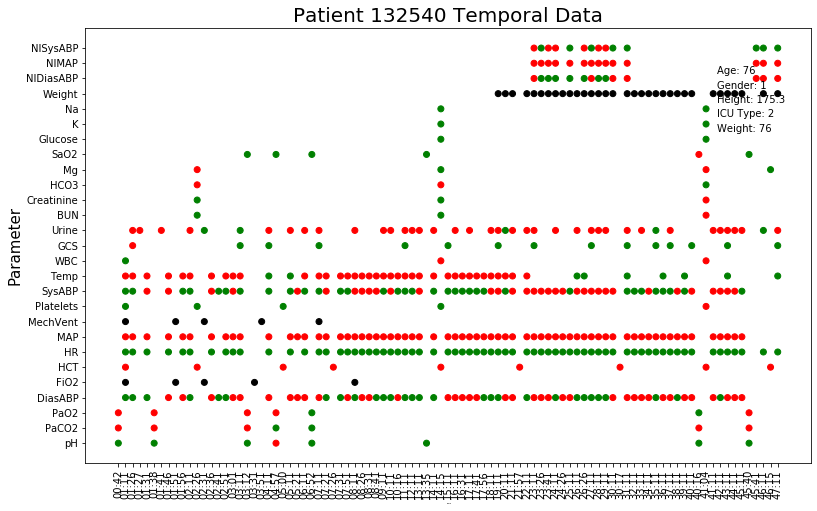

In [9]:
# print(list(v for k,v in temp_data.items() if '132539' in k.lower()))

record_id = '132540'
data = {"time":[], "parameter":[], "value":[], "normal":[]}
for coord in (list(v for k,v in temp_data.items() if record_id in k.lower())):
    data["time"].append(coord[0])
    data["parameter"].append(coord[1])
    if (coord[1] in time_series_values):
        is_normal = time_series_values[(coord[1])][0] <= float(coord[2]) <= time_series_values[(coord[1])][1]
        if (is_normal):
            data["normal"].append(1)
        else:
            data["normal"].append(0)
    else:
        data["normal"].append("NaN")

# display scatter plot data
plt.figure(figsize=(13,8))
plt.title('Patient ' + record_id +  ' Temporal Data', fontsize=20)
plt.xlabel('Time', fontsize=2)
plt.ylabel('Parameter', fontsize=15)
plt.xticks(rotation=90)
age = "Age: " + (general_desc[(record_id, 'Age')])[0]
gender = "Gender: " + (general_desc[(record_id, 'Gender')])[0]
height = "Height: " + (general_desc[(record_id, 'Height')])[0]
icu_type = "ICU Type: " + (general_desc[(record_id, 'ICUType')])[0]
weight = "Weight: " + (general_desc[(record_id, 'Weight')])[0]

plt.figtext(.8, .8, age)
plt.figtext(.8, .775, gender)
plt.figtext(.8, .75, height)
plt.figtext(.8, .725, icu_type)
plt.figtext(.8, .7, weight)

df = pd.DataFrame(dict(time=data["time"], parameter=data["parameter"], normal=data["normal"]))

color_labels = df['normal'].unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", 8)

# Map label to RGB
color_map = {1: 'green', 0:'red', 'NaN': 'black'}

plt.scatter(df["time"], df["parameter"], marker = 'o', c=df['normal'].map(color_map))

For data exploration, we also look into the general demographics of the patient's such as their age and gender in fold1.

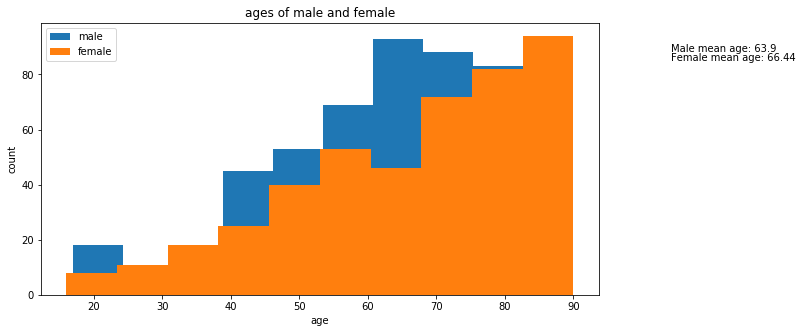

In [10]:
general_data = general_df_data[0]

plt.rcParams["figure.figsize"] = [10,5]
plt.hist(general_data[general_data["Gender"]=="1"]["Age"], label='male')
plt.hist(general_data[general_data["Gender"]=="0"]["Age"], label='female')

male_mean = "Male mean age: " + str(round(general_data[general_data["Gender"]=="1"]["Age"].mean(), 2))
female_mean = "Female mean age: " + str(round(general_data[general_data["Gender"]=="0"]["Age"].mean(), 2))

plt.figtext(1, .8, male_mean)
plt.figtext(1, .775, female_mean)

plt.xlabel("age")
plt.ylabel("count")
plt.title("ages of male and female")

plt.legend()

As shown above, most of the patient admitted are above the age of 50. With a mean of age 63.9 for males and 66.44 for females.

In [11]:
general_data[['Age', 'Height', 'Weight']].describe()

,Age,Height,Weight
count,1000.00000,1000.000000,1000.000000
mean,65.04500,88.333800,74.333770
std,17.18174,86.996894,32.097227
min,16.00000,-1.000000,-1.000000
25%,53.00000,-1.000000,60.950000
50%,68.00000,152.400000,75.000000
75%,79.00000,170.200000,91.300000
max,90.00000,406.400000,202.000000


### Standardising columns

From the above step, we can see that values for column Age, Height and Weight are reasonable except for -1 values for Height and Weight. However the team decides to embrace this as an indicator that the value is not available and is not an outlier.

For Gender column, since the challenge's website indicated 2 categories (0 = female, 1 = male), we will replace all values that are not 0 or 1 to -1.

For ICUType column, since the challenge's website indicated 4 categories  we will replace all values that are not 1, 2, 3 or 4 to -1.

In [12]:
# target_df_data[0].info()
# general_df_data[0].info()
# temporal_df_data[0].info()
# features_df_data[0].info()

for i in general_df_data:
    print(i['Gender'].unique())
    print(i['ICUType'].unique())

    
for i in general_df_data:
    i.loc[(i.Gender != '0') & (i.Gender != '1'), 'Gender'] = '-1'
    i.loc[(i.ICUType != '1') & (i.ICUType != '2') & (i.ICUType != '3') & (i.ICUType != '4'), 'ICUType'] = '-1'

    
# for i in general_df_data:
#     print(i['Gender'].unique())
#     print(i['ICUType'].unique())
    

['0' '1' '2']
['4' '2' '3' '1' '157.5' '162.6' '172.7' '-1']
['1' '0' '2' '-1' '4']
['4' '3' '2' '1' '167.6' '175.3' '149.9' '157.5']
['1' '0' '2' '3']
['2' '3' '1' '4' '152.4' '165.1' '-1']
[None '0' '1' '3' '2' '-1']
[None '3' '2' '1' '4' '-1' '167.6' '160' '180.3']


The way to construct a single feature vector for each patient in design matrix 2 is to get the relevant statistics for each feature. For example, in this design matrix, we will be finding the min, max, standard deviation and last value for each feature of the individual.

In [13]:
features_df_data[0].head()

,RecordID,Time,GCS,HR,NIDiasABP,NIMAP,NISysABP,Weight,RespRate,Temp,...,SaO2,Albumin,ALP,ALT,AST,Bilirubin,Lactate,Cholesterol,TroponinI,TroponinT
45688,132539,01:37,0.0,60.0,62.0,87.00,137.0,0.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45717,132539,30:37,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45716,132539,29:37,0.0,80.0,41.0,63.33,108.0,0.0,16.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45715,132539,28:37,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45714,132539,27:37,15.0,80.0,39.0,60.67,104.0,0.0,18.0,37.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Design Matrix 1


The first design matrix would be constructed by getting the mean of the features from each of the patient. Therefore, this would ignore the different time where the features are being measured to ensure that there is fair measurement of features across all patients.

Next, we combine the all of the patient data including both temporal and static data. This is so that we could have a holistic view of the patient information and allow more features to be included during the feature exploration process. The data is then stored is a list `mean_df_data`.

In [14]:
mean_df_data = []

for features_data, general_data, target_data in zip(features_df_data, general_df_data, target_df_data):
    features = features_data.groupby('RecordID').mean()
    features = features.rename(columns={"Weight": "TempWeight"})
    general = general_data[['Age', 'Gender', 'Height', 'Weight', 'ICUType']]
    target = target_data[['Length_of_stay', 'In-hospital_death']]
    features.reset_index(drop=True, inplace=True)
    general.reset_index(drop=True, inplace=True)
    target.reset_index(drop=True, inplace=True)
    mean_data = pd.concat([general_data['RecordID'], features, general, target], axis=1)
    mean_df_data.append(mean_data)

In [15]:
pd.set_option('display.precision', 4)
mean_df_data[0].head(10)

,RecordID,GCS,HR,NIDiasABP,NIMAP,NISysABP,TempWeight,RespRate,Temp,Urine,...,Cholesterol,TroponinI,TroponinT,Age,Gender,Height,Weight,ICUType,Length_of_stay,In-hospital_death
0,132592,3.8800,52.4000,34.1000,48.6602,77.7800,0.0000,14.6400,10.4600,122.0000,...,0.0000,0.0000,0.0,54.0,0,-1.0,-1.0,4,5,0
1,134685,2.1505,59.0753,8.5376,11.3368,16.9355,28.6753,0.0000,18.2710,66.8172,...,0.0000,0.0000,0.0,76.0,1,175.3,76.0,2,8,0
2,134849,1.1000,64.6143,42.8857,52.5221,71.8000,43.7400,0.0000,7.5600,73.1857,...,0.0000,0.0000,0.0,44.0,0,-1.0,56.7,3,19,0
3,133868,3.9559,62.6324,55.4853,71.5494,103.6765,73.4029,13.4118,6.9250,48.1618,...,0.0000,0.0000,0.0,68.0,1,180.3,84.6,3,9,0
4,134861,3.6000,71.9600,39.3200,64.4540,114.7200,0.0000,18.4000,11.0640,47.2200,...,0.0000,0.0000,0.0,88.0,0,-1.0,-1.0,3,4,0
5,134875,2.0968,67.1129,2.2742,2.6447,3.3871,0.0000,0.0000,5.4548,65.9677,...,3.4194,0.0210,0.0,64.0,1,180.3,114.0,1,6,0
6,132551,2.8571,64.0000,8.0000,11.3497,18.0476,80.0952,13.2381,7.5587,33.9841,...,0.0000,0.0238,0.0,68.0,0,162.6,87.0,3,9,0
7,133897,1.6383,55.0957,14.0426,25.2410,47.6383,35.5277,0.0000,14.1723,17.2447,...,0.0000,0.0702,0.0,78.0,0,162.6,48.4,3,6,1
8,134646,4.3750,121.9375,61.7917,80.9575,119.2917,58.1708,33.4792,7.6875,25.0000,...,0.0000,0.0000,0.0,64.0,0,-1.0,60.7,3,17,0
9,134134,2.1948,64.1688,1.3766,1.9655,3.1429,50.8013,0.0000,14.2922,61.5584,...,0.0000,0.0000,0.0,74.0,1,175.3,66.1,2,8,0


To ensure that the data that is rolled up to the record level is correct, we ensure that there are 1000 records in the dataframe.

In [16]:
mean_df_data[0].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 45 columns):
RecordID             1000 non-null object
GCS                  1000 non-null float64
HR                   1000 non-null float64
NIDiasABP            1000 non-null float64
NIMAP                1000 non-null float64
NISysABP             1000 non-null float64
TempWeight           1000 non-null float64
RespRate             1000 non-null float64
Temp                 1000 non-null float64
Urine                1000 non-null float64
HCT                  1000 non-null float64
BUN                  1000 non-null float64
Creatinine           1000 non-null float64
Glucose              1000 non-null float64
HCO3                 1000 non-null float64
Mg                   1000 non-null float64
Platelets            1000 non-null float64
K                    1000 non-null float64
Na                   1000 non-null float64
WBC                  1000 non-null float64
pH                   1000 non-null 

Next, we would explore the data by removing correlated features in the `mean_df_test` dataframe.

In [17]:
mean_df_target = []
mean_df_features = []

for mean_data in mean_df_data:
    mean_target = mean_data[['RecordID', 'Length_of_stay', 'In-hospital_death']]
    mean_target.replace(np.nan, 0, inplace=True)
    mean_df_target.append(mean_target)
    mean_features = mean_data.loc[:,'GCS':'ICUType']
    mean_features.replace(np.nan, 0, inplace=True)
    mean_df_features.append(mean_features)


/Users/apple/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


Design matrix 1 will based analysing on the different organs that are affected by the measurements using the mean data as a basis. The organ that the team have selected are Liver, Kidney and Heart, as they are major organs that would result in the mortality of the patient. 

**Feature Construction**

Since the team has decided on the different organs, we will added the different measurements of each organs to get an aggregated number of the health of the organ.

In [18]:
dm1_data = mean_df_features

for dm1_mean_features, target in zip(dm1_data, mean_df_target):
    dm1_mean_features['liver'] = dm1_mean_features['ALP'] + dm1_mean_features['ALT'] + dm1_mean_features['AST'] + dm1_mean_features['Bilirubin']
    dm1_mean_features['kidney'] = dm1_mean_features['Albumin'] + dm1_mean_features['BUN'] + dm1_mean_features['Creatinine'] + dm1_mean_features['DiasABP'] + dm1_mean_features['Glucose'] + dm1_mean_features['Urine']
    dm1_mean_features['heart'] = dm1_mean_features['Bilirubin'] + dm1_mean_features['BUN'] + dm1_mean_features['Cholesterol'] + dm1_mean_features['DiasABP'] + dm1_mean_features['Glucose'] + dm1_mean_features['HR'] + dm1_mean_features['Mg'] + dm1_mean_features['MAP'] + dm1_mean_features['NIMAP'] + dm1_mean_features['NISysABP'] + dm1_mean_features['SaO2'] + dm1_mean_features['Urine']
    dm1_mean_features['RecordID'] = target['RecordID']
    dm1_mean_features['Length_of_stay'] = target['Length_of_stay']
    dm1_mean_features['In-hospital_death'] = target['In-hospital_death']

In [19]:
mean_df_data[1].shape

(1001, 45)

In [20]:
corr_matrix = dm1_data[0].corr()

upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.98)]
to_drop


['NIMAP', 'NISysABP', 'MAP', 'SysABP']

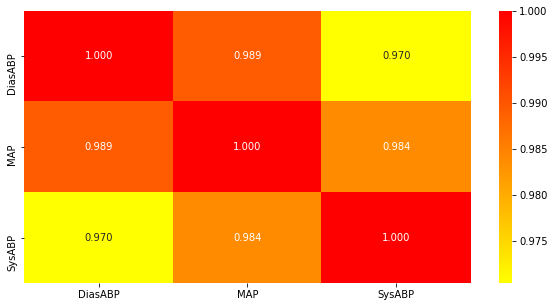

In [21]:
sns.heatmap(corr_matrix.loc[corr_matrix['SysABP'].abs() > 0.9, corr_matrix['SysABP'].abs() > 0.9],
            annot=True, cmap = plt.cm.autumn_r, fmt='.3f');

With the heatmap, it could be seen that the `to_drop` list's elements are highly correlated with one another therefore having only one of the element out of the four is sufficient. The element chosen to be kept is MAP as the two of the elements NIMAP and NISysABP are accounted for in heart and SysABP is highly correlated to the two.

In [22]:
to_drop.remove('MAP')

i = 0
for first_matrix in dm1_data:
    dm1_data[i] = first_matrix.drop(columns = to_drop)
    i += 1
    
dm1_data[0].head(5)


,GCS,HR,NIDiasABP,TempWeight,RespRate,Temp,Urine,HCT,BUN,Creatinine,...,Gender,Height,Weight,ICUType,liver,kidney,heart,RecordID,Length_of_stay,In-hospital_death
0,3.8800,52.4000,34.1000,0.0000,14.6400,10.460,122.0000,1.9500,0.4200,0.0300,...,0,-1.0,-1.0,4,0.0000,128.8500,307.7282,132592,5,0
1,2.1505,59.0753,8.5376,28.6753,0.0000,18.271,66.8172,2.7731,0.5914,0.0355,...,1,175.3,76.0,2,0.0000,113.2075,262.2959,134685,8,0
2,1.1000,64.6143,42.8857,43.7400,0.0000,7.560,73.1857,2.0329,0.2000,0.0143,...,0,-1.0,56.7,3,11.4686,94.5714,305.6564,134849,19,0
3,3.9559,62.6324,55.4853,73.4029,13.4118,6.925,48.1618,3.8544,0.7794,0.0338,...,1,180.3,84.6,3,1.9441,54.2162,292.0685,133868,9,0
4,3.6000,71.9600,39.3200,0.0000,18.4000,11.064,47.2200,3.5460,1.4000,0.0400,...,0,-1.0,-1.0,3,0.0000,52.8260,303.9160,134861,4,0


## Design Matrix 2

In [23]:
dm2_df = []

for features_data, general_data, target_data in zip(features_df_data, general_df_data, target_df_data):
    features_stats = features_data.groupby('RecordID', sort=False, as_index=True, axis=0)['GCS', 'HR', 'NIDiasABP', 'NIMAP', 'NISysABP', 'Weight',
              'RespRate', 'Temp', 'Urine', 'HCT', 'BUN', 'Creatinine', 'Glucose', 'HCO3', 'Mg', 'Platelets', 'K', 'Na', 
              'WBC', 'pH', 'PaCO2', 'PaO2', 'DiasABP', 'FiO2', 'MAP', 'MechVent', 'SysABP', 'SaO2', 'Albumin', 'ALP', 
              'ALT', 'AST', 'Bilirubin', 'Lactate', 'Cholesterol', 'TroponinI', 'TroponinT'].agg(['min','max', 'mean', 'std', 'sum'])
#     with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#         print(features_stats) #TO CHECK IF AGG IS CORRECT
    features_stats.reset_index(level=0, inplace=True)
    features_stats.columns = ['RecordID', 'GCS_min', 'GCS_max', 'GCS_mean', 'GCS_std', 'GCS_sum', 'HR_min ', 'HR _max ', 'HR_mean', 'HR_std', 'HR_sum', 'NIDiasABP_min ', 'NIDiasABP _max ', 'NIDiasABP_mean ', 'NIDiasABP_std', 'NIDiasABP_sum',
                              'NIMAP_min ', 'NIMAP _max ', 'NIMAP_mean', 'NIMAP_std', 'NIMAP_sum', 'NISysABP_min ', 'NISysABP _max ', 'NISysABP_mean ', 'NISysABP_std ','NISysABP_sum', 'Weight_min ', 'Weight _max ', 'Weight_mean ', 'Weight_std', 'Weight_sum', 
              'RespRate_min ', 'RespRate _max ', 'RespRate_mean ', 'RespRate_std ', 'RespRate_sum', 'Temp_min ', 'Temp _max ', 'Temp_mean', 'Temp_std', 'Temp_sum','Urine_min ', 'Urine _max',
                              'Urine_mean ', 'Urine_std ', 'Urine_sum','HCT_min ', 'HCT _max ', 'HCT_mean ', 'HCT_std ', 'HCT_sum','BUN_min ', 'BUN _max ', 'BUN_mean ', 'BUN_std ', 'BUN_sum','Creatinine_min ', 'Creatinine _max ', 'Creatinine_mean ', 'Creatinine_std ','Creatinine_sum', 'Glucose_min ', 'Glucose _max ', 'Glucose_mean', 'Glucose_std ','Glucose_sum', 'HCO3_min ', 'HCO3 _max ', 'HCO3_mean', 'HCO3_std ','HCO3_sum', 'Mg_min ', 'Mg _max ', 'Mg_mean', 'Mg_std ','Mg_sum', 'Platelets_min ', 'Platelets _max', 'Platelets_mean', 'Platelets_std ', 'Platelets_sum','K_min ', 'K_max ', 'K_mean', 'K_std ', 'K_sum','Na_min ', 'Na_max ', 'Na_mean', 'Na_std ',  'Na_sum',  
              'WBC_min ', 'WBC_max ', 'WBC_mean ', 'WBC_std','WBC_sum', 'pH_min ', 'pH_max ', 'pH_mean', 'pH_std ','pH_sum', 'PaCO2_min ', 'PaCO2_max ', 'PaCO2_mean ', 'PaCO2_std','PaCO2_sum', 'PaO2_min ', 'PaO2_max ', 'PaO2_mean ', 'PaO2_std ','PaO2_sum', 'DiasABP_min ', 'DiasABP_max ', 'DiasABP_mean ', 'DiasABP_std ','DiasABP_sum', 'FiO2_min ', 'FiO2_max ', 'FiO2_mean', 'FiO2_std ','FiO2_sum', 'MAP_min ', 'MAP_max ', 'MAP_mean', 'MAP_std ','MAP_sum', 'MechVent_min ', 'MechVent_max ', 'MechVent_mean', 'MechVent_std ','MechVent_sum', 'SysABP_min ', 'SysABP_max ', 'SysABP_mean', 'SysABP_std ','SysABP_sum', 'SaO2_min ', 'SaO2_max ', 'SaO2_mean', 'SaO2_std ','SaO2_sum', 'Albumin_min ', 'Albumin_max ', 'Albumin_mean', 'Albumin_std ','Albumin_sum', 'ALP_min ', 'ALP_max ', 'ALP_mean', 'ALP_std ','ALP_sum',  
              'ALT_min ', 'ALT_max ', 'ALT_mean', 'ALT_std ','ALT_sum', 'AST_min ', 'AST_max ', 'AST_mean', 'AST_std ','AST_sum', 'Bilirubin_min ', 'Bilirubin_max ', 'Bilirubin_mean', 'Bilirubin_std ','Bilirubin_sum', 'Lactate_min ', 'Lactate_max ', 'Lactate_mean', 'Lactate_std ','Lactate_sum', 'Cholesterol_min ', 'Cholesterol_max ', 'Cholesterol_mean', 'Cholesterol_std ', 'Cholesterol_sum',  'TroponinI_min ', 'TroponinI_max ', 'TroponinI_mean', 'TroponinI_std ','TroponinI_sum', 'TroponinT_min ', 'TroponinT_max ', 'TroponinT_mean', 'TroponinT_std ','TroponinT_sum']

    
    general = general_data[['Age', 'Gender', 'Height', 'Weight', 'ICUType']]
    target = target_data[['Length_of_stay', 'In-hospital_death']]
    features_stats.reset_index(drop=True, inplace=True)
    general.reset_index(drop=True, inplace=True)
    target.reset_index(drop=True, inplace=True)
    print(features_stats.head())
    print(general.tail())
    print(target.head())
    mean_data = pd.concat([features_stats, general, target], axis=1)
    dm2_df.append(mean_data)

dm2_data = dm2_df

  RecordID  GCS_min  GCS_max  GCS_mean  GCS_std  GCS_sum  HR_min   HR _max   \
0   132539      0.0     15.0    3.8800   6.6137    194.0      0.0      86.0   
1   132540      0.0     15.0    2.1505   5.0925    200.0      0.0      90.0   
2   132541      0.0      8.0    1.1000   2.3722     77.0      0.0     113.0   
3   132543      0.0     15.0    3.9559   6.6432    269.0      0.0      88.0   
4   132545      0.0     15.0    3.6000   6.4713    180.0      0.0      94.0   

   HR_mean   HR_std  ...  TroponinI_min   TroponinI_max   TroponinI_mean  \
0  52.4000  32.2307  ...             0.0             0.0             0.0   
1  59.0753  36.4701  ...             0.0             0.0             0.0   
2  64.6143  36.8402  ...             0.0             0.0             0.0   
3  62.6324  24.1574  ...             0.0             0.0             0.0   
4  71.9600  16.5369  ...             0.0             0.0             0.0   

   TroponinI_std   TroponinI_sum  TroponinT_min   TroponinT_max   \


In [24]:
# print(dm2_data[0]['In-hospital_death'].unique())
# print(dm2_data[1]['In-hospital_death'].unique())
# print(dm2_data[2]['In-hospital_death'].unique())
# print(dm2_data[3]['In-hospital_death'].unique())

# print(target_df_data[0]['In-hospital_death'].unique())
# print(target_df_data[1]['In-hospital_death'].unique())
# print(target_df_data[2]['In-hospital_death'].unique())
# print(target_df_data[3]['In-hospital_death'].unique())


# print(target_df_data[1].describe())
# print(general_df_data[1].describe())
# print(features_df_data[1].describe())


In [25]:
pd.set_option('display.precision', 4)
print(dm2_df[0].head())

  RecordID  GCS_min  GCS_max  GCS_mean  GCS_std  GCS_sum  HR_min   HR _max   \
0   132539      0.0     15.0    3.8800   6.6137    194.0      0.0      86.0   
1   132540      0.0     15.0    2.1505   5.0925    200.0      0.0      90.0   
2   132541      0.0      8.0    1.1000   2.3722     77.0      0.0     113.0   
3   132543      0.0     15.0    3.9559   6.6432    269.0      0.0      88.0   
4   132545      0.0     15.0    3.6000   6.4713    180.0      0.0      94.0   

   HR_mean   HR_std  ...  TroponinT_mean  TroponinT_std   TroponinT_sum   Age  \
0  52.4000  32.2307  ...             0.0             0.0            0.0  54.0   
1  59.0753  36.4701  ...             0.0             0.0            0.0  76.0   
2  64.6143  36.8402  ...             0.0             0.0            0.0  44.0   
3  62.6324  24.1574  ...             0.0             0.0            0.0  68.0   
4  71.9600  16.5369  ...             0.0             0.0            0.0  88.0   

   Gender  Height  Weight  ICUType  Le

### Checking for redundant variables
Let's first look if there is any null values from our newly created dataframe

In [26]:
# frames = [dm2_data[0], dm2_data[1], dm2_data[2], dm2_data[3]]
# result = pd.concat(frames)


# result.replace(np.nan, 0, inplace=True)

i = 0
#dm2_df[0]
a = []
print('dm2_data df:')    
while (i < 4 ):
    missing = pd.DataFrame(dm2_df[i].isnull().sum()).rename(columns = {0: 'total'})
    i = i + 1
    a.append(missing)


frames = [a[0], a[1], a[2], a[3]]
result = pd.concat(frames)
result = pd.DataFrame(result.groupby(result.index)['total'].sum())
print(result.sort_values('total', ascending = False).head(50))

dm2_data df:
                  total
SaO2_std              9
PaCO2_std             9
Lactate_std           9
TroponinT_std         9
Bilirubin_std         9
Na_std                9
Cholesterol_std       9
TroponinI_std         9
K_std                 9
Creatinine_std        9
Temp_std              9
DiasABP_std           9
NISysABP_std          9
SysABP_std            9
HR_std                9
FiO2_std              9
PaO2_std              9
GCS_std               9
HCT_std               9
Platelets_std         9
RespRate_std          9
Glucose_std           9
BUN_std               9
HCO3_std              9
Urine_std             9
MAP_std               9
MechVent_std          9
ALT_std               9
AST_std               9
NIMAP_std             9
NIDiasABP_std         9
WBC_std               9
Mg_std                9
Albumin_std           9
ALP_std               9
pH_std                9
Weight_std            9
Platelets_min         3
Platelets_mean        3
NIMAP_mean            3
NID

From the above list generated, we can see that there seems to be a trend whereby the standard deviation columns have the most frequent number of null values. From the standard deviation formula, we know that to get a null value, the number of occurence, n must be 1 such that the denominator of the stndard deviation = 0. Therefore, for standard deviation with null values, we will impute it with 0 as there is only 1 such record of that feature hence standard deviaion would be 0.

In [27]:
stdCols = []
columns = dm2_df[0].columns
for i in columns:
    if 'std' in i:
        stdCols.append(i)
        
print(stdCols)

i = 0
while (i < 4 ):
    dm2_data[i][stdCols] = dm2_data[i][stdCols].fillna(0)
    i = i + 1 

['GCS_std', 'HR_std', 'NIDiasABP_std', 'NIMAP_std', 'NISysABP_std ', 'Weight_std', 'RespRate_std ', 'Temp_std', 'Urine_std ', 'HCT_std ', 'BUN_std ', 'Creatinine_std ', 'Glucose_std ', 'HCO3_std ', 'Mg_std ', 'Platelets_std ', 'K_std ', 'Na_std ', 'WBC_std', 'pH_std ', 'PaCO2_std', 'PaO2_std ', 'DiasABP_std ', 'FiO2_std ', 'MAP_std ', 'MechVent_std ', 'SysABP_std ', 'SaO2_std ', 'Albumin_std ', 'ALP_std ', 'ALT_std ', 'AST_std ', 'Bilirubin_std ', 'Lactate_std ', 'Cholesterol_std ', 'TroponinI_std ', 'TroponinT_std ']


Now we check if there is anymore null values in the dataframe for design matrix 2

In [28]:
i = 0
#dm2_df[0]
a = []
result = []
print('dm2_data df:')    
while (i < 4 ):
    missing = pd.DataFrame(dm2_data[i].isnull().sum()).rename(columns = {0: 'total'})
    i = i + 1
    a.append(missing)


frames = [a[0], a[1], a[2], a[3]]
result = pd.concat(frames)
result = pd.DataFrame(result.groupby(result.index)['total'].sum())
print(result.sort_values('total', ascending = False).head(30))

dm2_data df:
                total
ALP_max             3
PaCO2_max           3
NISysABP _max       3
NISysABP_mean       3
NISysABP_min        3
NISysABP_sum        3
Na_max              3
Na_mean             3
Na_min              3
Na_sum              3
PaCO2_mean          3
NIMAP_min           3
PaCO2_min           3
PaCO2_sum           3
PaO2_max            3
PaO2_mean           3
PaO2_min            3
PaO2_sum            3
Platelets _max      3
Platelets_mean      3
NIMAP_sum           3
NIMAP_mean          3
Lactate_mean        3
MechVent_min        3
Lactate_sum         3
Length_of_stay      3
MAP_max             3
MAP_mean            3
MAP_min             3
MAP_sum             3


In [29]:
# for i in dm2_data:
#     with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#         print(i)


# dm2_data[1].fillna(-100, inplace=True)
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):    
#     print(dm2_data[1])
    

i = 0
#dm2_df[0]
a = []
result = []
print('dm2_data df:')    
while (i < 4 ):
    dm2_data[i].fillna(0, inplace=True)
    missing = pd.DataFrame(dm2_data[i].isnull().sum()).rename(columns = {0: 'total'})
    i = i + 1
    print(missing)
    

dm2_data df:
                   total
RecordID               0
GCS_min                0
GCS_max                0
GCS_mean               0
GCS_std                0
GCS_sum                0
HR_min                 0
HR _max                0
HR_mean                0
HR_std                 0
HR_sum                 0
NIDiasABP_min          0
NIDiasABP _max         0
NIDiasABP_mean         0
NIDiasABP_std          0
NIDiasABP_sum          0
NIMAP_min              0
NIMAP _max             0
NIMAP_mean             0
NIMAP_std              0
NIMAP_sum              0
NISysABP_min           0
NISysABP _max          0
NISysABP_mean          0
NISysABP_std           0
NISysABP_sum           0
Weight_min             0
Weight _max            0
Weight_mean            0
Weight_std             0
...                  ...
Bilirubin_mean         0
Bilirubin_std          0
Bilirubin_sum          0
Lactate_min            0
Lactate_max            0
Lactate_mean           0
Lactate_std            0
Lactate_sum 

If there are any variables that are too highly correlated, then we might want to remove one of the pair of highly correlated variables.
The following step identifies any variables with a greater than 0.95 absolute magnitude correlation.

In [30]:
# # Create correlation matrix
# corr_matrix = dm2_data[0].corr()

# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# # Find index of feature columns with correlation greater than 0.95
# to_drop = [column for column in upper.columns if any(abs(upper[column]) > 0.95)]

# to_drop



to_drop = []
for i in range(0, len(dm2_data)):
    # Create correlation matrix
    corr_matrix = dm2_data[i].corr()
    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    # Find index of feature columns with correlation greater than 0.95
    to_drop.append([column for column in upper.columns if any(abs(upper[column]) > 0.95)])
        
#     dm2_data[i] = dm2_data[i].drop(columns = to_drop[i])
#     print("Correlated columns dropped for fold " + str(i+1))
#     print("\n")


toDrop = set(to_drop[0]) & set(to_drop[1]) & set(to_drop[2]) & set(to_drop[3]) 
print('Common features to drop across the 4 folds:\n')
print(toDrop)

Common features to drop across the 4 folds:

{'SysABP_sum', 'NISysABP_std ', 'Cholesterol_sum', 'RespRate_std ', 'ALT_std ', 'NISysABP_sum', 'NIMAP_mean', 'ALT_sum', 'NIMAP _max ', 'NIMAP_sum', 'MAP_std ', 'MAP_sum', 'SysABP_std ', 'Bilirubin_std ', 'TroponinT_std ', 'AST_sum', 'TroponinI_std ', 'Na_mean', 'Creatinine_std ', 'MAP_mean', 'SysABP_mean', 'Weight_std', 'RespRate_mean ', 'NISysABP_mean ', 'NIMAP_std', 'AST_std ', 'TroponinT_sum'}


These show one out of each pair of correlated variables. To find the other pair, we can subset the `corr_matrix`. 

In [31]:
for i in range(0, len(dm2_data)):
    print('Folder' + str(i+1) + '\n')
    corr_matrix = dm2_data[i].corr()
    for i in toDrop:
        print(corr_matrix.loc[corr_matrix[i].abs() > 0.99, corr_matrix[i].abs() > 0.99])

Folder1

            SysABP_sum
SysABP_sum         1.0
               NISysABP_std 
NISysABP_std             1.0
                 Cholesterol_sum
Cholesterol_sum              1.0
               RespRate_std 
RespRate_std             1.0
          ALT_std 
ALT_std        1.0
              NISysABP_sum
NISysABP_sum           1.0
            NIMAP_mean
NIMAP_mean         1.0
         ALT_sum
ALT_sum      1.0
             NIMAP _max 
NIMAP _max           1.0
           NIMAP_sum
NIMAP_sum        1.0
          MAP_std 
MAP_std        1.0
             DiasABP_sum  MAP_sum
DiasABP_sum       1.0000   0.9908
MAP_sum           0.9908   1.0000
             SysABP_std 
SysABP_std           1.0
                Bilirubin_std 
Bilirubin_std              1.0
                TroponinT_std 
TroponinT_std              1.0
         AST_sum
AST_sum      1.0
                TroponinI_std 
TroponinI_std              1.0
         Na_mean
Na_mean      1.0
                 Creatinine_std 
Creatinine_std        

There seems to be no perfectly correlated features across the 4 folders for us to remove.

<b>Data exploration for Data matrix 2</b>

In [32]:
for i in dm2_data:
    corrs = i.corr()['In-hospital_death']
    print(corrs.sort_values().head())

GCS_std       -0.2077
Urine_mean    -0.2071
Urine_sum     -0.2009
Urine_std     -0.1971
GCS_max       -0.1770
Name: In-hospital_death, dtype: float64
Height            -0.0700
Temp_mean         -0.0485
NISysABP_mean     -0.0473
NIDiasABP_mean    -0.0445
Temp_sum          -0.0435
Name: In-hospital_death, dtype: float64
Height           -0.0640
HR_mean          -0.0517
HR_sum           -0.0490
Bilirubin_mean   -0.0443
TroponinI_max    -0.0432
Name: In-hospital_death, dtype: float64
RespRate_mean    -0.0884
RespRate _max    -0.0798
RespRate_sum     -0.0795
GCS_std          -0.0780
RespRate_std     -0.0751
Name: In-hospital_death, dtype: float64


In [33]:
corrs.sort_values().dropna().tail()

Glucose_sum          0.1206
HCO3_sum             0.1226
Na_sum               0.1253
K_sum                0.1256
In-hospital_death    1.0000
Name: In-hospital_death, dtype: float64

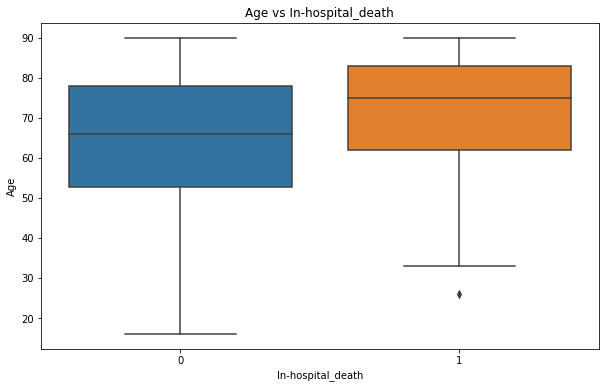

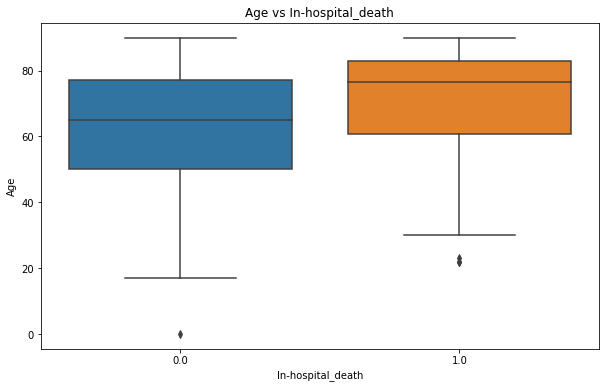

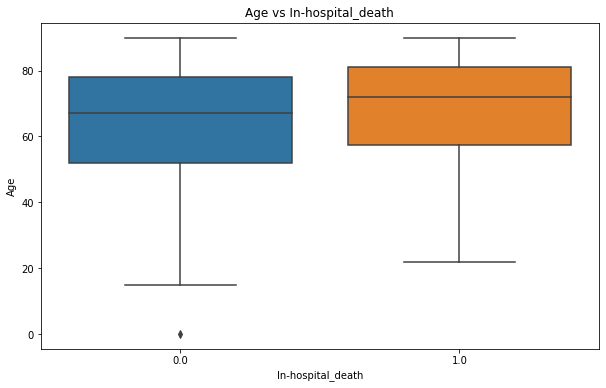

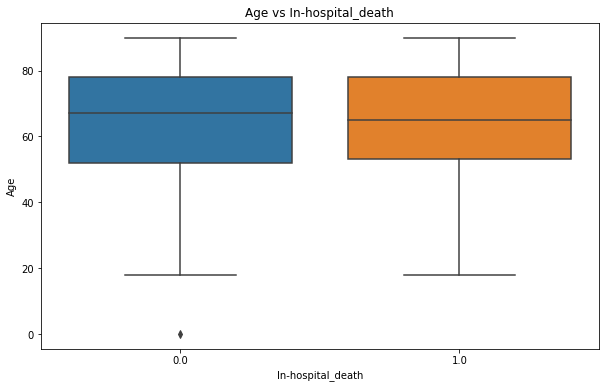

In [34]:
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'In-hospital_death', y = 'Age', data = dm2_data[0]);
plt.title('Age vs In-hospital_death');

plt.figure(figsize = (10, 6))
sns.boxplot(x = 'In-hospital_death', y = 'Age', data = dm2_data[1]);
plt.title('Age vs In-hospital_death');

plt.figure(figsize = (10, 6))
sns.boxplot(x = 'In-hospital_death', y = 'Age', data = dm2_data[2]);
plt.title('Age vs In-hospital_death');

plt.figure(figsize = (10, 6))
sns.boxplot(x = 'In-hospital_death', y = 'Age', data = dm2_data[3]);
plt.title('Age vs In-hospital_death');

From the box and whiskers graph we can see that the older the age, the higher the number of in hospital deaths (denoted by 1.0)

In [35]:
corrs = dm2_data[0].corr()['Length_of_stay']
corrs.sort_values().head()

GCS_std          -0.2105
RespRate _max    -0.1912
RespRate_mean    -0.1911
RespRate_std     -0.1874
RespRate_sum     -0.1807
Name: Length_of_stay, dtype: float64

In [36]:
corrs.sort_values().dropna().tail()

pH_std            0.2164
HR_std            0.2214
MechVent_std      0.2265
MechVent_sum      0.2383
Length_of_stay    1.0000
Name: Length_of_stay, dtype: float64

## Design Matrix 3


For the last design matrix, it is mainly to drop features which are not considered vital. As for outliers, after much considerations and research, the team has decided to keep all of them as we do not have enough domain expertise on the measurements as these outliers may indicate poor patient health which are important for our study. Furthermore, we made a hypothesis that patients who have multiple readings of some feature that exhibited large standard deviations could indicate failing health, and therefore, we decided to group data of each feature using standard deviation.

At the end, the team had also tried to eliminate features with low correlation with the targets - but was unable to do so.

Reference from: https://towardsdatascience.com/predicting-mortality-in-the-icu-2e4832cc94d2

First, we will group every feature using standard deviation to get the main design matrix 3 dataframe `dm3_data`.

In [37]:
dm3_data = []

for features_data, general_data, target_data in zip(features_df_data, general_df_data, target_df_data):
    features = features_data.groupby('RecordID').std()
    general = general_data[['Age', 'Gender', 'Height', 'Weight', 'ICUType']]
    target = target_data[['Length_of_stay', 'In-hospital_death']]
    features.reset_index(drop=True, inplace=True)
    general.reset_index(drop=True, inplace=True)
    target.reset_index(drop=True, inplace=True)
    std_data = pd.concat([general_data['RecordID'], features, general, target], axis=1)
    std_data.replace(np.nan, 0, inplace=True)
    dm3_data.append(std_data)

As mentioned above, dropping of features which are not considered vital - such as Height and Gender may help to improve the training data.

Height will not fluctuate a lot (unless it is a growing child/teenager) and has no effect on whether a patient is healthy/unhealthy.

Although males have higher probability of getting certain illnesses than females and vice versa, it is still not very important as there are endless varieties of illnesses and it is very hard for non-medicine students to analyse based on this. If analysed wrongly, it may give wrong predictions.

In [38]:
for i in range(0, len(dm3_data)):
    dm3_data[i] = dm3_data[i].drop(columns = ['Height', 'Gender'])

Let's now take a look at the design matrix after doing the above mentioned feature engineering so far.

In [39]:
dm3_data[0].head()

,RecordID,GCS,HR,NIDiasABP,NIMAP,NISysABP,Weight,RespRate,Temp,Urine,...,Bilirubin,Lactate,Cholesterol,TroponinI,TroponinT,Age,Weight,ICUType,Length_of_stay,In-hospital_death
0,132592,6.6137,32.2307,24.5201,34.5654,55.1252,0.0000,7.0934,16.9505,162.9198,...,0.0000,0.0000,0.0,0.0,0.0,54.0,-1.0,4,5,0
1,134685,5.0925,36.4701,20.7289,27.4108,40.8879,38.8761,0.0000,18.5814,130.6345,...,0.0000,0.0000,0.0,0.0,0.0,76.0,76.0,2,8,0
2,134849,2.3722,36.8402,39.9940,48.8455,66.7202,23.9809,0.0000,15.2317,94.2375,...,0.4869,0.2917,0.0,0.0,0.0,44.0,56.7,3,19,0
3,133868,6.6432,24.1574,24.0239,30.4818,44.0412,28.8819,6.1577,14.3513,167.6392,...,0.0243,0.0000,0.0,0.0,0.0,68.0,84.6,3,9,0
4,134861,6.4713,16.5369,19.7716,27.6550,48.0340,0.0000,4.9611,17.0740,43.4705,...,0.0000,0.0000,0.0,0.0,0.0,88.0,-1.0,3,4,0


**Correlation Heatmap**

In order to show the correlations between the features and the targets, we will pick 5 variables and display it on a correlation heatmap.

The 5 variables we have chosen are `Age`, `HR`, `RespRate`, `NISysABP`, `ICUType`.

These 5 include general information, heart condition and breathing condition of patients, which we think may present useful findings when compared with the targets - `Length_of_stay` and `In-hospital_death`.

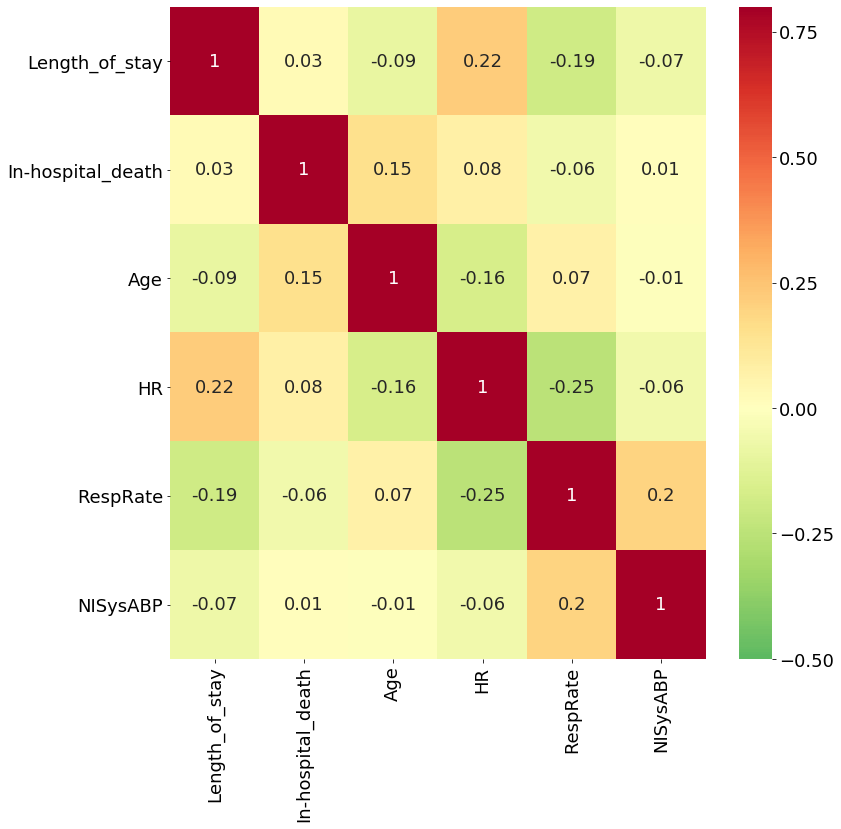

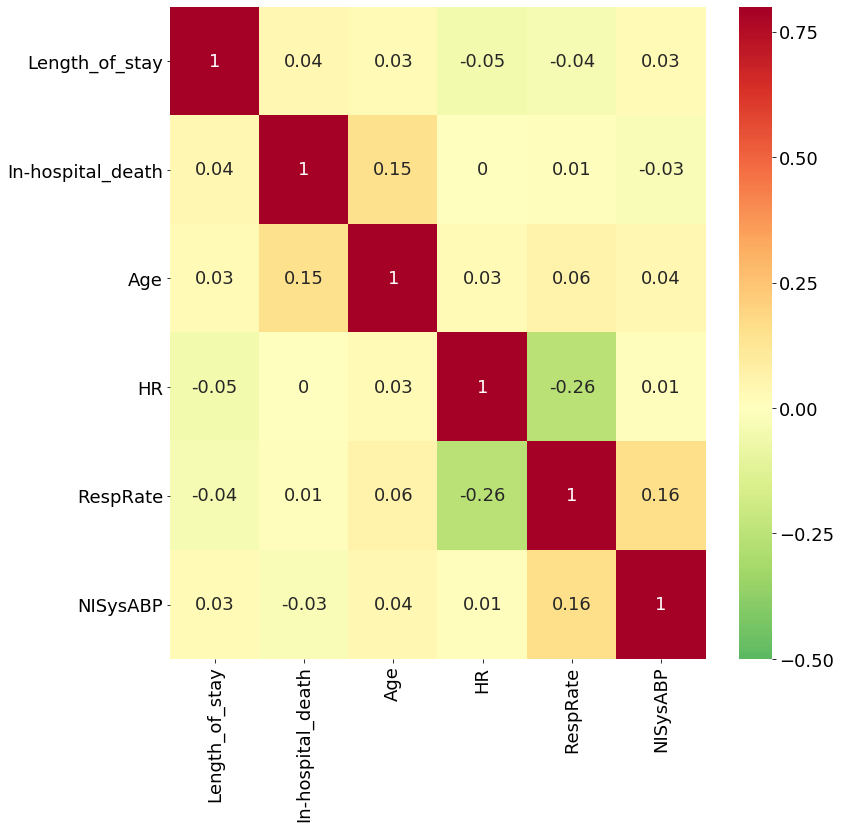

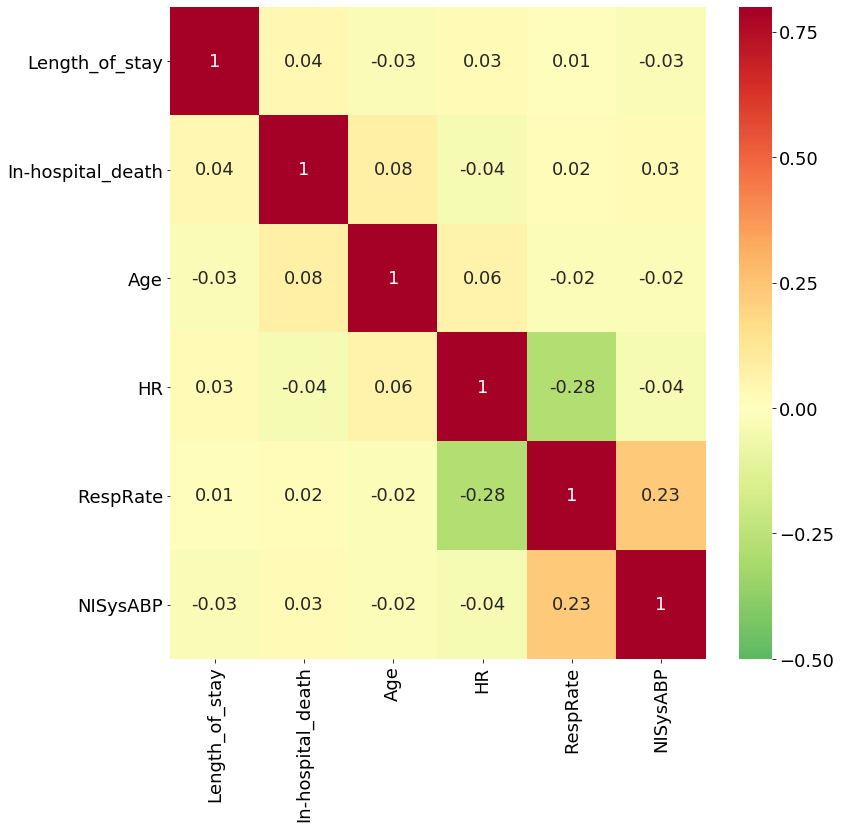

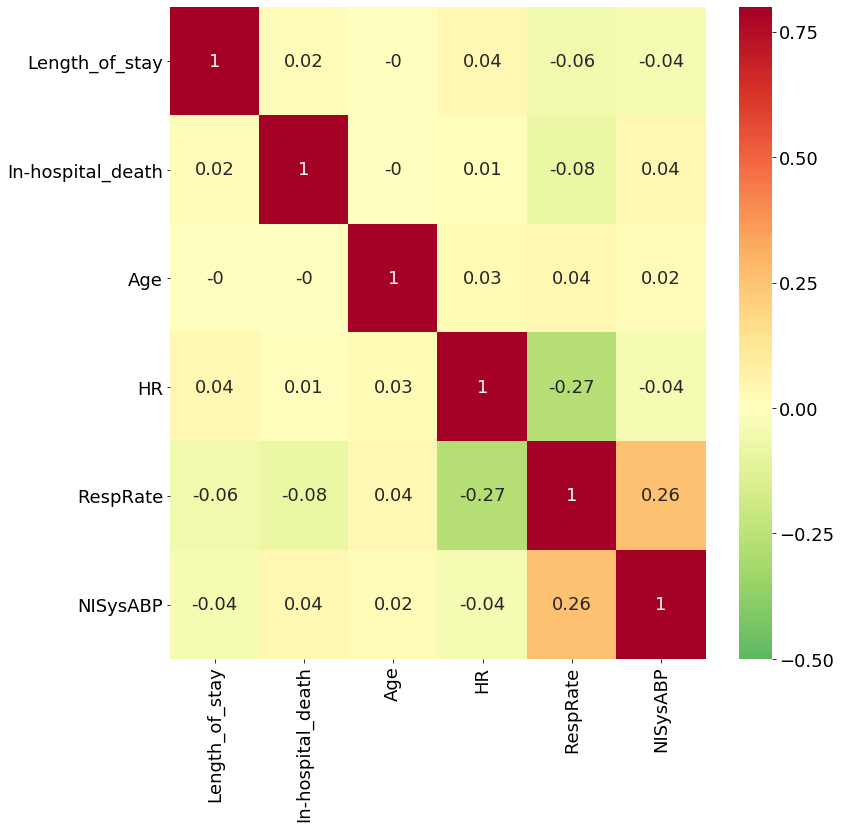

In [40]:
variables = ['Length_of_stay', 'In-hospital_death', 'Age', 'HR', 'RespRate', 'NISysABP', 'ICUType']

for i in range(0, len(dm3_data)):
    # Calculate the correlations
    corr_mat = dm3_data[i][variables].corr().round(2)

    # Draw a correlation heatmap
    plt.rcParams['font.size'] = 18
    plt.figure(figsize = (12, 12))
    sns.heatmap(corr_mat, vmin = -0.5, vmax = 0.8, center = 0, 
                cmap = plt.cm.RdYlGn_r, annot = True);

This plot shows us that there are a number of variables that have a weak correlation with the both the targets. However, we have chosen not to do anything to these features as they are not as severe.

Now, we wil move on to model building.

# Model Building

First, we will create 4 iterations from the 4 folds provided in the data folders. This will be used to test the models.

**Iteration 1:  Training data: fold 1, 2, 3, Test data: fold 4**

**Iteration 2:  Training data: fold 1, 2, 4, Test data: fold 3**

**Iteration 3:  Training data: fold 1, 3, 4, Test data: fold 2**

**Iteration 4:  Training data: fold 4, 2, 3, Test data: fold 1**


In [41]:
model = dm1_data
dm1_iterations_train = []
dm1_iterations_test = []

# iteration 1:
dm1_iterations_train.append(model[0].append(model[1]).append(model[2]))
dm1_iterations_test.append(model[3])

# iteration 2:
dm1_iterations_train.append(model[0].append(model[1]).append(model[3]))
dm1_iterations_test.append(model[2])

# iteration 3:
dm1_iterations_train.append(model[0].append(model[2]).append(model[3]))
dm1_iterations_test.append(model[1])

# iteration 4:
dm1_iterations_train.append(model[1].append(model[2]).append(model[3]))
dm1_iterations_test.append(model[0])

model = dm2_data
dm2_iterations_train = []
dm2_iterations_test = []

# iteration 1:
dm2_iterations_train.append(model[0].append(model[1]).append(model[2]))
dm2_iterations_test.append(model[3])

# iteration 2:
dm2_iterations_train.append(model[0].append(model[1]).append(model[3]))
dm2_iterations_test.append(model[2])

# iteration 3:
dm2_iterations_train.append(model[0].append(model[2]).append(model[3]))
dm2_iterations_test.append(model[1])

# iteration 4:
dm2_iterations_train.append(model[1].append(model[2]).append(model[3]))
dm2_iterations_test.append(model[0])

model = dm3_data
dm3_iterations_train = []
dm3_iterations_test = []

# iteration 1:
dm3_iterations_train.append(model[0].append(model[1]).append(model[2]))
dm3_iterations_test.append(model[3])

# iteration 2:
dm3_iterations_train.append(model[0].append(model[1]).append(model[3]))
dm3_iterations_test.append(model[2])

# iteration 3:
dm3_iterations_train.append(model[0].append(model[2]).append(model[3]))
dm3_iterations_test.append(model[1])

# iteration 4:
dm3_iterations_train.append(model[1].append(model[2]).append(model[3]))
dm3_iterations_test.append(model[0])

# Classification

Model 1 would be just pure classfication for mortality. For now idk what to test so just use mean data later then change.

In [42]:
model1 = Pipeline(memory=None,steps=[
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=500, multi_class='auto'))])

hparam_grid = {'classifier__C': [1., 0.5]}
estimator = GridSearchCV(model1, hparam_grid, scoring = 'roc_auc')

scores_train = []
scores_test = []

for iteration_train, iteration_test in zip(dm1_iterations_train, dm1_iterations_test):
    X_train = iteration_train.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_train = iteration_train['In-hospital_death']
    X_test = iteration_test.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_test = iteration_test['In-hospital_death']
    estimator.fit(X_train, Y_train);
    scores_train.extend(cross_val_score(model1, X_train, Y_train, scoring='roc_auc'))
    scores_test.extend(cross_val_score(estimator.best_estimator_, X_test, Y_test, scoring='roc_auc'))
    
print("TRAIN - Mean score: ", np.mean(scores_train), "Standard deviation: ", np.std(scores_train))
print("TEST - Mean score: ", np.mean(scores_test), " Standard deviation", np.std(scores_test))

TRAIN - Mean score:  0.5500678030490495 Standard deviation:  0.03276512836636148
TEST - Mean score:  0.5979227326483094  Standard deviation 0.09747596911250123


In [43]:
model1 = Pipeline(steps=[
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=500, multi_class='auto'))])

hparam_grid = {'classifier__C': [1., 0.5]}
estimator = GridSearchCV(model1, hparam_grid, scoring = 'roc_auc')

scores_train = []
scores_test = []

for iteration_train, iteration_test in zip(dm2_iterations_train, dm2_iterations_test):
    X_train = iteration_train.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_train = iteration_train['In-hospital_death']
    X_test = iteration_test.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_test = iteration_test['In-hospital_death']
    estimator.fit(X_train, Y_train);
    scores_train.extend(cross_val_score(model1, X_train, Y_train, scoring='roc_auc'))
    scores_test.extend(cross_val_score(estimator.best_estimator_, X_test, Y_test, scoring='roc_auc'))
    
print("TRAIN - Mean score: ", np.mean(scores_train), "Standard deviation: ", np.std(scores_train))
print("TEST - Mean score: ", np.mean(scores_test), " Standard deviation", np.std(scores_test))

TRAIN - Mean score:  0.5415468250918966 Standard deviation:  0.018396918777999424
TEST - Mean score:  0.5799594957362325  Standard deviation 0.09769261554029168


In [44]:
model1 = Pipeline(memory=None,steps=[
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=500, multi_class='auto'))])

hparam_grid = {'classifier__C': [1., 0.5]}
estimator = GridSearchCV(model1, hparam_grid, scoring = 'roc_auc')

scores_train = []
scores_test = []

for iteration_train, iteration_test in zip(dm3_iterations_train, dm3_iterations_test):
    X_train = iteration_train.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_train = iteration_train['In-hospital_death']
    X_test = iteration_test.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_test = iteration_test['In-hospital_death']
    estimator.fit(X_train, Y_train);
    scores_train.extend(cross_val_score(model1, X_train, Y_train, scoring='roc_auc'))
    scores_test.extend(cross_val_score(estimator.best_estimator_, X_test, Y_test, scoring='roc_auc'))
    
print("TRAIN - Mean score: ", np.mean(scores_train), "Standard deviation: ", np.std(scores_train))
print("TEST - Mean score: ", np.mean(scores_test), " Standard deviation", np.std(scores_test))

TRAIN - Mean score:  0.5363863156149173 Standard deviation:  0.031763499409288215
TEST - Mean score:  0.601235914315826  Standard deviation 0.09381053721019522


In [45]:
model1V2 = Pipeline(memory=None,steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(whiten=True)),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1200, multi_class='auto'))])

hparam_grid = {
    'classifier__C': [0.025, 0.1, 0.2]}
estimator = GridSearchCV(model1V2, hparam_grid, scoring = 'roc_auc')

scores_train = []
scores_test = []

for iteration_train, iteration_test in zip(dm3_iterations_train, dm3_iterations_test):
    X_train = iteration_train.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_train = iteration_train['In-hospital_death']
    X_test = iteration_test.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_test = iteration_test['In-hospital_death']
    estimator.fit(X_train, Y_train);
    scores_train.extend(cross_val_score(model1V2, X_train, Y_train, scoring='roc_auc'))
    scores_test.extend(cross_val_score(estimator.best_estimator_, X_test, Y_test, scoring='roc_auc'))
    
print("TRAIN - Mean score: ", np.mean(scores_train), "Standard deviation: ", np.std(scores_train))
print("TEST - Mean score: ", np.mean(scores_test), " Standard deviation", np.std(scores_test))
print(estimator.best_params_)

TRAIN - Mean score:  0.551331791949215 Standard deviation:  0.03374931196851514
TEST - Mean score:  0.6145490842787867  Standard deviation 0.10079540037656193
{'classifier__C': 0.2}


For the second model for classification, the team uses:

In [46]:
model1V2 = Pipeline(memory=None,steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(whiten=True)),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1200, multi_class='auto'))])

hparam_grid = {
    'classifier__C': [0.025, 0.1, 0.2]}
estimator = GridSearchCV(model1V2, hparam_grid, scoring = 'roc_auc')

scores_train = []
scores_test = []

for iteration_train, iteration_test in zip(dm3_iterations_train, dm3_iterations_test):
    X_train = iteration_train.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_train = iteration_train['In-hospital_death']
    X_test = iteration_test.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_test = iteration_test['In-hospital_death']
    estimator.fit(X_train, Y_train);
    scores_train.extend(cross_val_score(model1V2, X_train, Y_train, scoring='roc_auc'))
    scores_test.extend(cross_val_score(estimator.best_estimator_, X_test, Y_test, scoring='roc_auc'))
    
print("TRAIN - Mean score: ", np.mean(scores_train), "Standard deviation: ", np.std(scores_train))
print("TEST - Mean score: ", np.mean(scores_test), " Standard deviation", np.std(scores_test))
print(estimator.best_params_)

TRAIN - Mean score:  0.551331791949215 Standard deviation:  0.03374931196851514
TEST - Mean score:  0.6145490842787867  Standard deviation 0.10079540037656193
{'classifier__C': 0.2}


In [47]:
# classifier_names = ['KNeighborsClassifier', 'SVC', 'LogisticRegression', 
#                     'DecisionTreeClassifier', 'RandomForestClassifier',
#                    'AdaBoostClassifier', 'GradientBoostingClassifier'
#                    ]
# classifiers = [
#     KNeighborsClassifier(3),
#     SVC(kernel="rbf", C=0.025, probability=True),
# #     NuSVC(probability=True),
#     LogisticRegression(solver='lbfgs', max_iter=500, multi_class='auto'),
#     DecisionTreeClassifier(),
#     RandomForestClassifier(),
#     AdaBoostClassifier(),
#     GradientBoostingClassifier()
#     ]

# hparam_grid = {
#     'f_selecter__k': [ 5, 7, 9, 11],
# }



# i = 0
# for classifier in classifiers:
#     model1V2 = Pipeline(memory=None,steps=[('f_selecter', SelectKBest()), 
#                                ('classifier', classifier)])
#     estimator = GridSearchCV(model1V2, hparam_grid, cv=4, scoring = 'roc_auc')
    
#     scores_train = []
#     scores_test = []

#     for iteration_train, iteration_test in zip(dm1_iterations_train, dm1_iterations_train):
#         X_train = iteration_train.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
#         Y_train = iteration_train['In-hospital_death']
#         X_test = iteration_test.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
#         Y_test = iteration_test['In-hospital_death']
#         X_train = StandardScaler().fit_transform(X_train)
#         model1V2.fit(X_train, Y_train)
#         scores_train.extend(cross_val_score(model1V2, X_train, Y_train, scoring='roc_auc'))
#         X_test = StandardScaler().fit_transform(X_test)
#         scores_test.extend(cross_val_score(model1V2, X_test, Y_test, scoring='roc_auc'))
#     print(classifier_names[i])
#     print("TRAIN - Mean score: ", np.mean(scores_train), "Standard deviation: ", np.std(scores_train))
#     print("TEST - Mean score: ", np.mean(scores_test), " Standard deviation", np.std(scores_test))
#     print('\n')
#     i += 1

## Random Forest Classification

Automatic feature selection:

### Recursive Feature Elimination with Random Forest

The `RFECV` in Sklearn stands for Recursive Feature Elimination with Cross Validation. The selector operates using a model with feature importances in an iterative manner. At each iteration, it removes either a fraction of features or a set number of features. The iterations continue until the cross validation score no longer improves. 

To create the `selector` object, we pass in the the model, the number of features to remove at each iteration, the cross validation folds, our custom scorer, and any other parameters to guide the selection.

In [48]:
# from sklearn.feature_selection import RFECV
# from sklearn.metrics import f1_score, make_scorer
# from sklearn.preprocessing import MinMaxScaler

# # Custom scorer for cross validation
# scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')
# # Create a model for feature selection
# estimator = RandomForestClassifier(random_state = 0, n_estimators = 100,  n_jobs = -1)

# # Create the object
# selector = RFECV(estimator, step = 1, cv = 3, scoring= scorer, n_jobs = -1)
# selector.fit(X, Y)

# plt.plot(selector.grid_scores_);

# plt.xlabel('Number of Features'); plt.ylabel('Macro F1 Score'); plt.title('Feature Selection Scores');
# selector.n_features_


# rankings = pd.DataFrame({'feature': list(X.columns), 'rank': list(selector.ranking_)}).sort_values('rank')
# print(selector.n_features_)
# print(rankings)

The rankings of each feature can be found by inspecting the trained object. These represent essentially the importance of features averaged over the iterations. Features can share the same ranking, and only features with a rank of 1 are retained.

In [49]:
# rankings = pd.DataFrame({'feature': list(X.columns), 'rank': list(selector.ranking_)}).sort_values('rank')
# print(rankings)

# Regression

Now, let's move on to train all of our 3 design matrices with regression models.

This is started off by training a linear model as shown below. At the same time, there is a comparison of the model performance on the test data as compared to the training data using a plot graph.

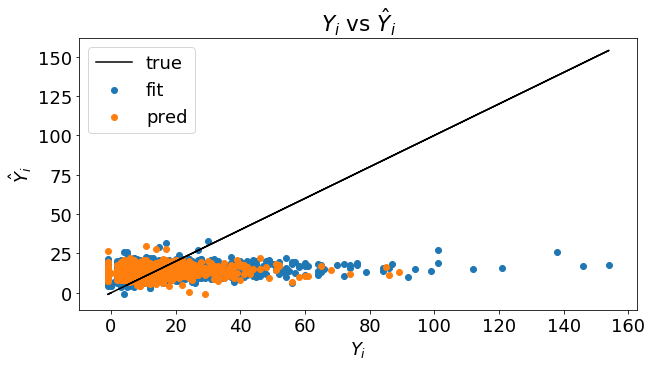

In [50]:
model2 = LinearRegression()

X_train = dm1_iterations_train[0].drop(columns=['RecordID', 'Length_of_stay', 'In-hospital_death'])
Y_train = dm1_iterations_train[0]['Length_of_stay']
X_test = dm1_iterations_test[0].drop(columns=['RecordID', 'Length_of_stay', 'In-hospital_death'])
Y_test = dm1_iterations_test[0]['Length_of_stay']
model2.fit(X_train, Y_train)
        
Y_fit = model2.predict(X_train)
Y_pred = model2.predict(X_test)
        
plt.plot(Y_train, Y_train, c='k', label="true")

plt.scatter(Y_train, Y_fit, label='fit')
plt.scatter(Y_test, Y_pred, label='pred')
plt.xlabel("$Y_i$"); plt.ylabel("$\hat{Y}_i$"); plt.title("$Y_i$ vs $\hat{Y}_i$")
plt.legend()   

From the graph plotted above, the higher values of samples with higher value of  𝑦  are neither fitted nor predicted well. This was seen in week 5's tutorial (Sklearn) as well.
Let's check how to compare the training and test accruracy of the model by using some metrics.

In [51]:
Y_fit_data = []
Y_pred_data = []
yTest_data = []
for iteration_train, iteration_test in zip(dm3_iterations_train, dm3_iterations_test):
    X_train = iteration_train.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_train = iteration_train['Length_of_stay']
    X_test = iteration_test.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_test = iteration_test['Length_of_stay']
    model2.fit(X_train, Y_train)
    yTest_data.append(Y_test)
    Y_fit_data.append(model2.predict(X_train))
    Y_pred_data.append(model2.predict(X_test))

scores = []    
for yTest, yPred in zip(yTest_data, Y_pred_data):
    rmse = np.sqrt(mean_squared_error(yTest, yPred))
    scores.append(rmse)


print("mean of rmse over 4-fold: ", np.mean(scores))

mean of rmse over 4-fold:  12.289605923564968


Make it better with polynomial (better model)

In [52]:
predictors = ['liver', 'kidney', 'heart']
poly2_predictors = []
for p in predictors:
    poly2_predictors.append('I('+ p +'**4)'.format(p,p))
poly2_predictors

yPred_data = []
yTest_data = []

for iteration_train, iteration_test in zip(dm1_iterations_train, dm1_iterations_test):
    X_train = iteration_train.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_train = iteration_train['Length_of_stay']
    X_test = iteration_test.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_test = iteration_test['Length_of_stay']
    data = iteration_train.drop(columns=['RecordID'])
#     linear = ols(formula='Length_of_stay ~ '+ ' + '.join(predictors), data=data).fit()
    poly2 = ols(formula='Length_of_stay ~ '+ ' + '.join(poly2_predictors), data=data).fit()
    yPred_data.append(poly2.predict(X_test))
    yTest_data.append(Y_test)
    

scores = []    
for yTest, yPred in zip(yTest_data, yPred_data):
    rmse = np.sqrt(mean_squared_error(yTest, yPred))
    scores.append(rmse)

print("mean of rmse over 4-fold: ", np.mean(scores))
# print('R-squred poly2: ', poly2.rsquared)

mean of rmse over 4-fold:  12.282813058670047


In [53]:
model2V2 = Pipeline(steps=[
#     ('over', SMOTE()),
#     ('under', RandomUnderSampler(random_state=0, replacement=True)),
    ('f_selecter', SelectKBest()), 
    ('scaling', StandardScaler()),
    ('pca', PCA(whiten=False)),
    ('polynomial', PolynomialFeatures(include_bias=True)),
    ('regression', LinearRegression(fit_intercept=True))])

hparam_grid = {
#     'pca__n_components': [20, 25],
#     'f_selecter__k': [14, 15, 16, 17],
    'polynomial__degree': [1, 2, 3]}
estimator = GridSearchCV(model2V2, hparam_grid)

yPred_data = []
scores = []
yTest_data = []

for iteration_train, iteration_test in zip(dm1_iterations_train, dm1_iterations_test):
    X_train = iteration_train.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_train = iteration_train['Length_of_stay']
    X_test = iteration_test.drop(columns=['RecordID', 'In-hospital_death', 'Length_of_stay'])
    Y_test = iteration_test['Length_of_stay']
    yTest_data.append(iteration_test['Length_of_stay'])
    estimator.fit(X_train, Y_train);
    yPred_data.append(estimator.best_estimator_.predict(X_test))

scores = [] 
for yTest, yPred in zip(yTest_data, yPred_data):
    rmse = np.sqrt(mean_squared_error(yTest, yPred))
    print(rmse)
    scores.append(rmse)
    
print("mean of rmse over 4-fold: ", np.mean(scores))
print("best param: ", estimator.best_params_)

/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/apple/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


11.183803897949819
11.863544785352618
11.689946629192152
13.998364850261488
mean of rmse over 4-fold:  12.183915040689019
best param:  {'polynomial__degree': 1}


# Printing predictions for best trained model:

to append recordID column

In [54]:
def printPrediction(clf):
    clf.fit(X_train, Y_train)
    prediction = clf.predict(X_train)
    predictionOutput = pd.DataFrame(prediction, columns = ['ouput'])
    print(predictionOutput)

In [55]:
printPrediction(model2V2)

        ouput
0     15.2918
1     16.2700
2     15.2337
3     12.2559
4     12.8129
5      8.1065
6     11.9085
7     15.5684
8     14.4019
9     13.3457
10    11.7999
11    13.3422
12    12.4726
13    12.9224
14    11.5731
15    12.0340
16    11.0158
17     9.8448
18    12.1921
19    14.7238
20    13.5234
21    15.4786
22    11.5371
23    12.2006
24    12.5951
25    11.9974
26    15.2919
27    11.3517
28    13.2082
29    11.9821
...       ...
2973  12.8491
2974  12.9007
2975  13.0600
2976  16.2943
2977  12.0651
2978  10.9075
2979  14.4187
2980  13.2900
2981  13.4940
2982  14.7863
2983  12.9328
2984  17.4540
2985  12.0409
2986  12.4781
2987  13.3517
2988  12.7286
2989  23.0898
2990  13.6952
2991  16.3639
2992  12.9053
2993  12.4655
2994  12.1273
2995  12.2146
2996   8.8836
2997  14.3597
2998  15.4730
2999  14.3003
3000  12.4446
3001  11.6457
3002  13.7454

[3003 rows x 1 columns]
